In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import streamlit as st
import joblib
from xgboost import XGBClassifier
import re
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

In [2]:
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [3]:
# Load the dataset
df = pd.read_excel("drugsCom_raw.xlsx")
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [4]:
# EDA

In [5]:
# Rename 'Unnamed: 0' to 'Drug ID'
df.rename(columns={'Unnamed: 0': 'Drug ID'}, inplace=True)

In [6]:
# Drop the 'date' column
df.drop('date', axis=1, inplace=True)

In [7]:
# Filter for the specified conditions
target_conditions = ['Depression', 'High Blood Pressure', 'Diabetes, Type 2']
df_filtered = df[df['condition'].isin(target_conditions)].copy()

In [8]:
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13944 entries, 11 to 161290
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Drug ID      13944 non-null  int64 
 1   drugName     13944 non-null  object
 2   condition    13944 non-null  object
 3   review       13944 non-null  object
 4   rating       13944 non-null  int64 
 5   usefulCount  13944 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 762.6+ KB


In [9]:
df_filtered['condition'].unique()


array(['Depression', 'Diabetes, Type 2', 'High Blood Pressure'],
      dtype=object)

In [10]:
# Check for null values
print("Null Value Check:")
print(df_filtered.isnull().sum())

Null Value Check:
Drug ID        0
drugName       0
condition      0
review         0
rating         0
usefulCount    0
dtype: int64


In [11]:
df_filtered.describe()

,Drug ID,rating,usefulCount
count,13944.000000,13944.000000,13944.000000
mean,125186.191050,6.862952,45.737880
std,64495.952023,3.207061,51.782627
min,870.000000,1.000000,0.000000
25%,74605.750000,4.000000,16.000000
50%,124638.500000,8.000000,31.000000
75%,182921.500000,10.000000,59.000000
max,232218.000000,10.000000,1291.000000


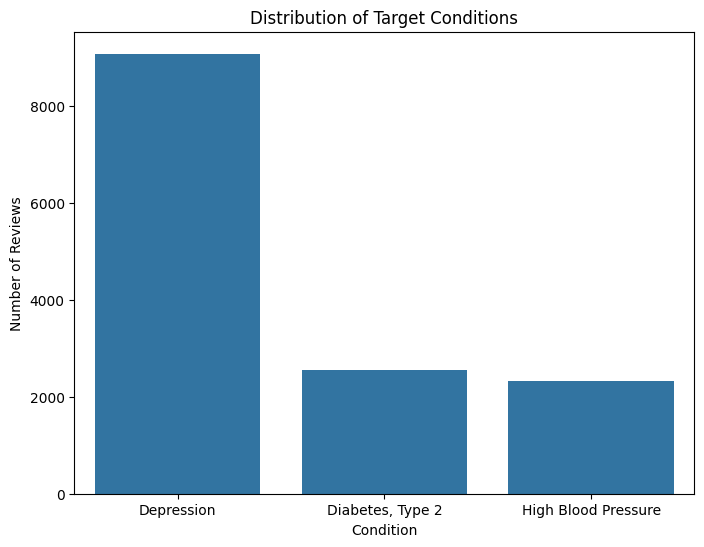

In [12]:
plt.figure(figsize=(8, 6))
condition_counts = df_filtered['condition'].value_counts()
sns.barplot(x=condition_counts.index, y=condition_counts.values)
plt.title('Distribution of Target Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Reviews')
plt.show()

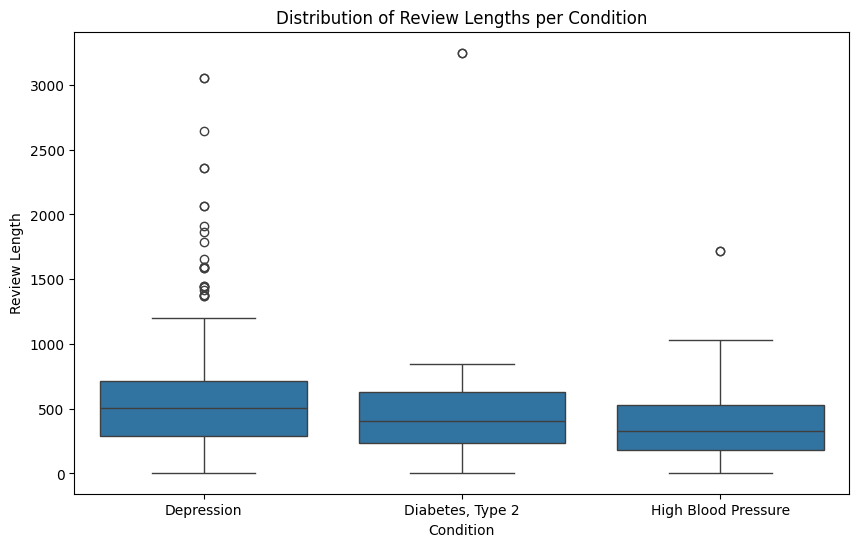

In [13]:
df_filtered['review_length'] = df_filtered['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='review_length', data=df_filtered)
plt.title('Distribution of Review Lengths per Condition')
plt.xlabel('Condition')
plt.ylabel('Review Length')
plt.show()

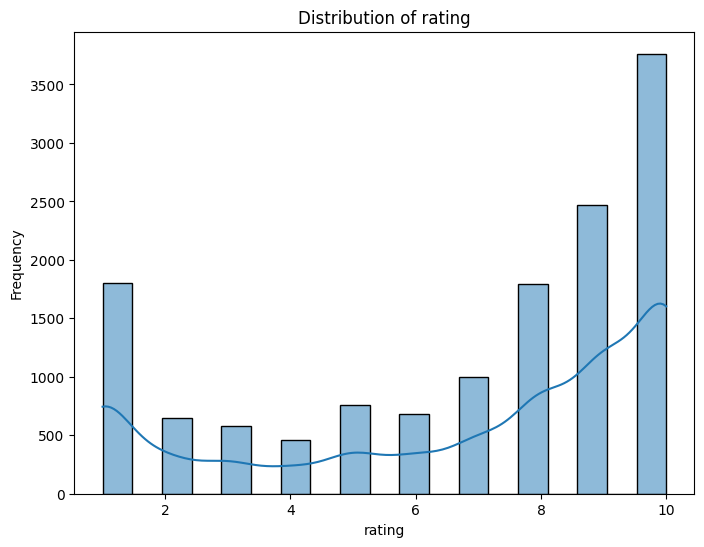

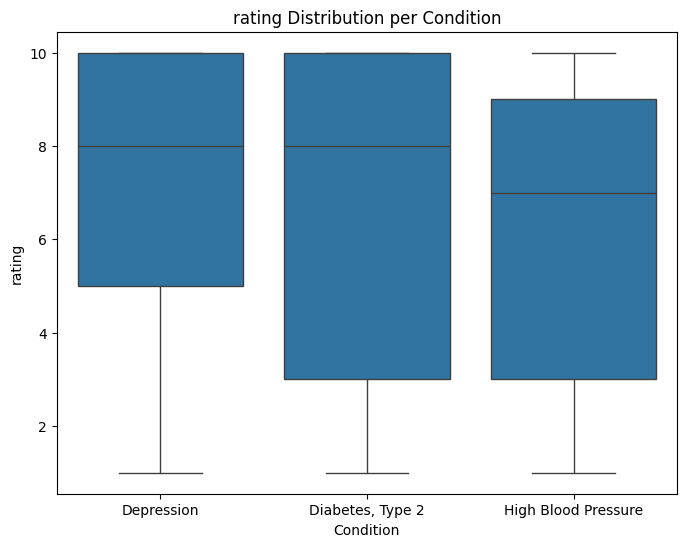

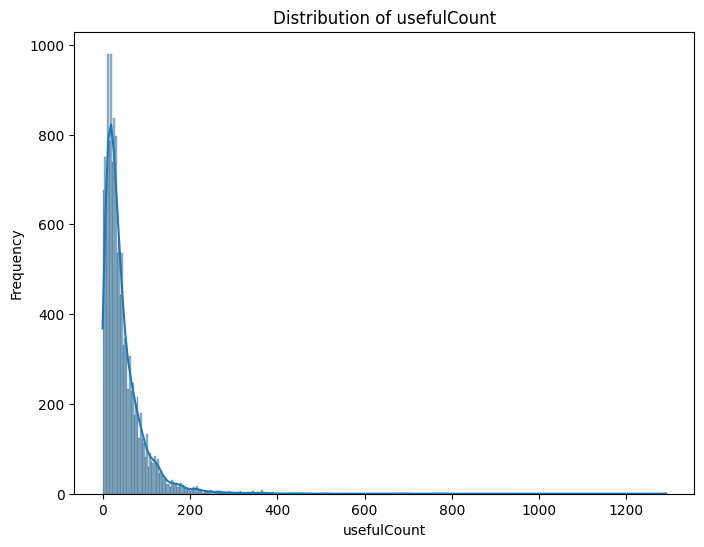

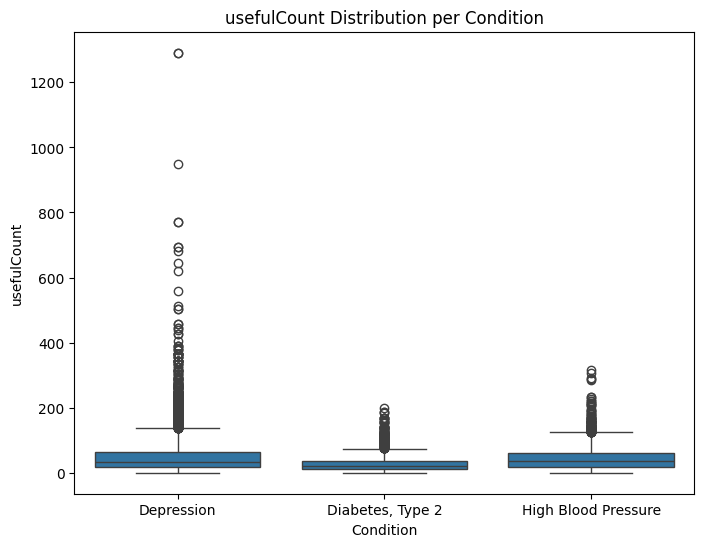

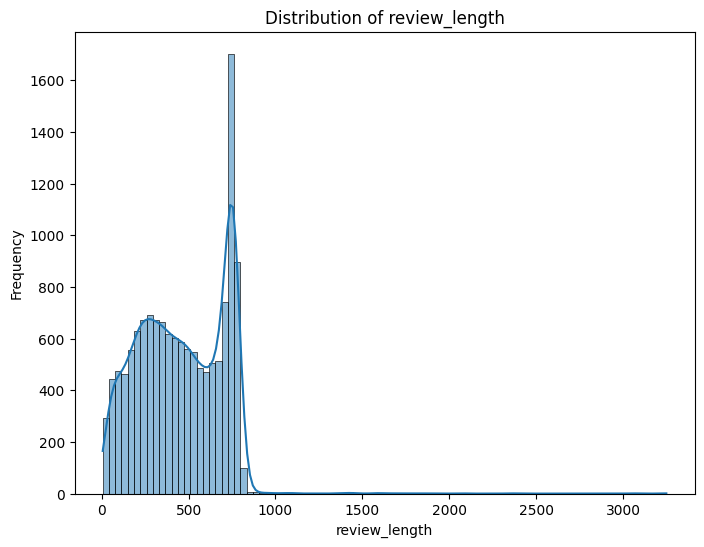

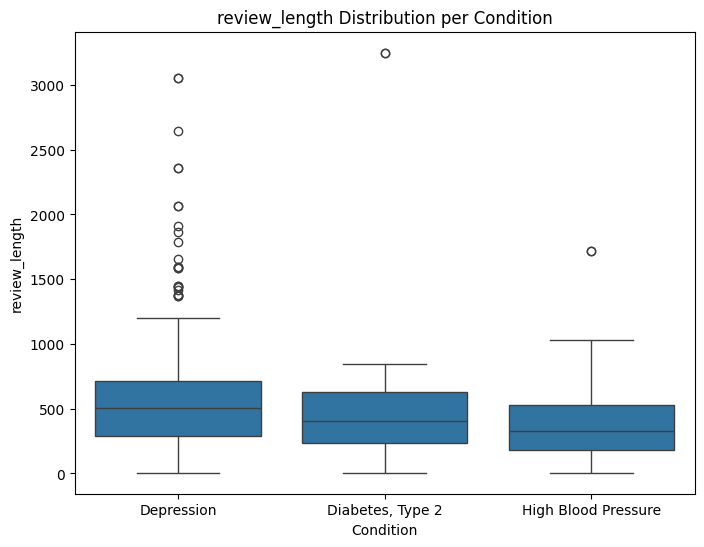

In [14]:
# 2. Distribution of Numerical Features
numerical_features = ['rating', 'usefulCount', 'review_length']
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_filtered[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='condition', y=feature, data=df_filtered)
    plt.title(f'{feature} Distribution per Condition')
    plt.xlabel('Condition')
    plt.ylabel(feature)
    plt.show()

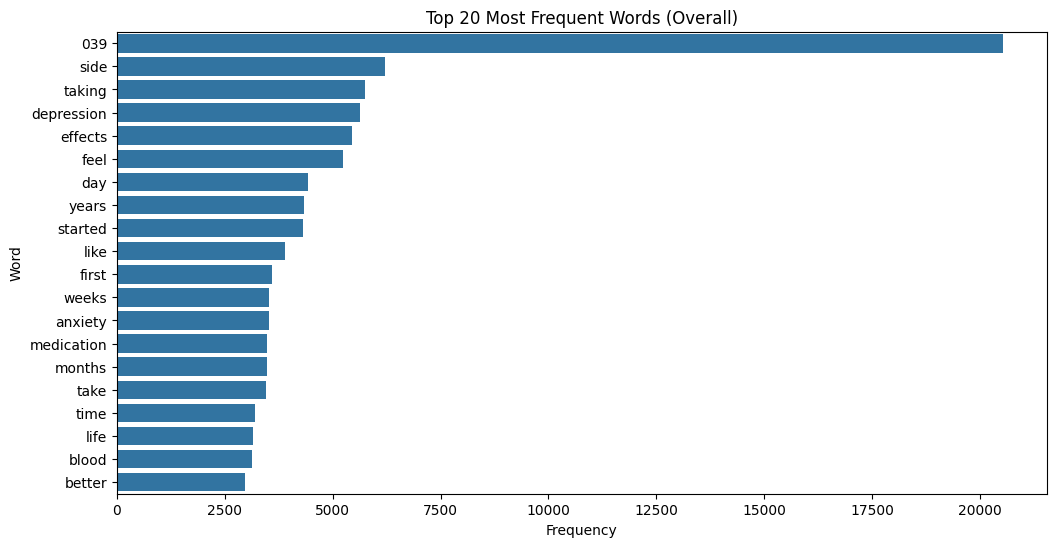

In [15]:
# 4. Word Frequency Analysis (Overall)
stop_words = set(stopwords.words('english'))
all_reviews_text = ' '.join(df_filtered['review'])
tokens = word_tokenize(all_reviews_text.lower())
tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
word_counts = Counter(tokens)
top_common_words = word_counts.most_common(20)
top_words_df = pd.DataFrame(top_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=top_words_df)
plt.title('Top 20 Most Frequent Words (Overall)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [16]:
stop_words = set(stopwords.words('english'))
N = 10

In [17]:
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

for condition in target_conditions:
    subset = df_filtered[df_filtered['condition'] == condition]['review']
    top_words = get_top_n_words(subset, N)
    print(f"\nTop {N} words for {condition}:")
    print(pd.DataFrame(top_words, columns=['Word', 'TF-IDF Score']))


Top 10 words for Depression:
         Word  TF-IDF Score
0         039    673.147108
1  depression    331.599611
2        feel    287.674666
3      taking    265.229903
4     effects    256.973919
5     anxiety    251.873223
6       years    231.900022
7         day    227.207449
8        life    223.882447
9          ve    222.213526

Top 10 words for High Blood Pressure:
         Word  TF-IDF Score
0         039    123.147514
1    pressure    115.018052
2       blood    112.890814
3     effects     87.349747
4      taking     76.664153
5    medicine     63.668939
6       years     62.963156
7  medication     54.457035
8         day     53.395067
9          bp     51.961921

Top 10 words for Diabetes, Type 2:
      Word  TF-IDF Score
0      039    161.292458
1    sugar     79.994421
2    blood     79.768297
3  effects     71.921291
4   taking     68.332956
5      day     66.201669
6   weight     65.519789
7     lost     65.396982
8  started     63.028455
9  victoza     62.670596


In [18]:
def remove_039(text):
  """Removes the string '039' from a given text."""
  if isinstance(text, str):  
    return text.replace("039", "")# since it is present in 8205 Samples we have replaced the string 
  return text

# Apply the function to the 'review_text' column
df_filtered['review'] = df_filtered['review'].apply(remove_039)

In [19]:
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

for condition in target_conditions:
    subset = df_filtered[df_filtered['condition'] == condition]['review']
    top_words = get_top_n_words(subset, N)
    print(f"\nTop {N} words for {condition}:")
    print(pd.DataFrame(top_words, columns=['Word', 'TF-IDF Score']))


Top 10 words for Depression:
         Word  TF-IDF Score
0  depression    333.489214
1        feel    289.913249
2      taking    267.067770
3     effects    258.607111
4     anxiety    253.427709
5       years    233.277561
6         day    228.795034
7          ve    226.369716
8        life    225.148941
9        like    223.346783

Top 10 words for High Blood Pressure:
         Word  TF-IDF Score
0    pressure    115.557080
1       blood    113.407291
2     effects     87.703537
3      taking     77.074519
4    medicine     63.862093
5       years     63.282879
6  medication     54.714911
7         day     53.722611
8          bp     52.234348
9      doctor     52.021645

Top 10 words for Diabetes, Type 2:
      Word  TF-IDF Score
0    sugar     80.359816
1    blood     80.117544
2  effects     72.349163
3   taking     68.788656
4      day     66.505396
5   weight     66.044295
6     lost     65.857061
7  started     63.432046
8  victoza     63.057470
9    weeks     61.585467


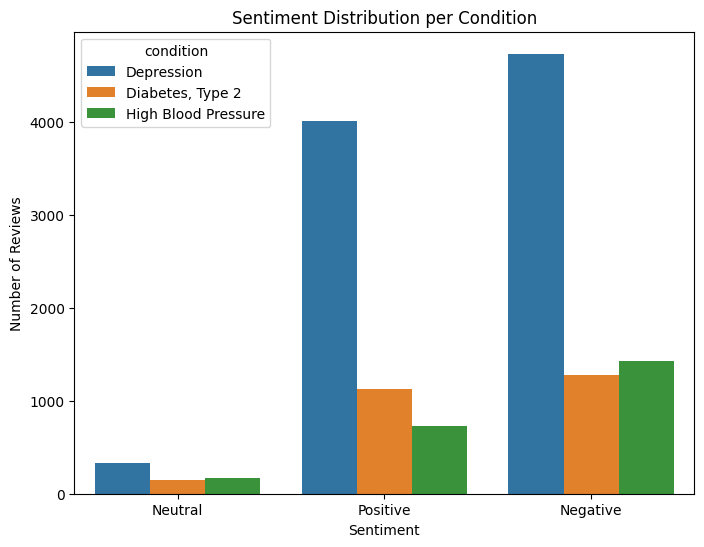

In [20]:
# 3. Sentiment Analysis Breakdown
analyzer = SentimentIntensityAnalyzer()
df_filtered['sentiment_score'] = df_filtered['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_filtered['sentiment'] = df_filtered['sentiment_score'].apply(categorize_sentiment)

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', hue='condition', data=df_filtered)
plt.title('Sentiment Distribution per Condition')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

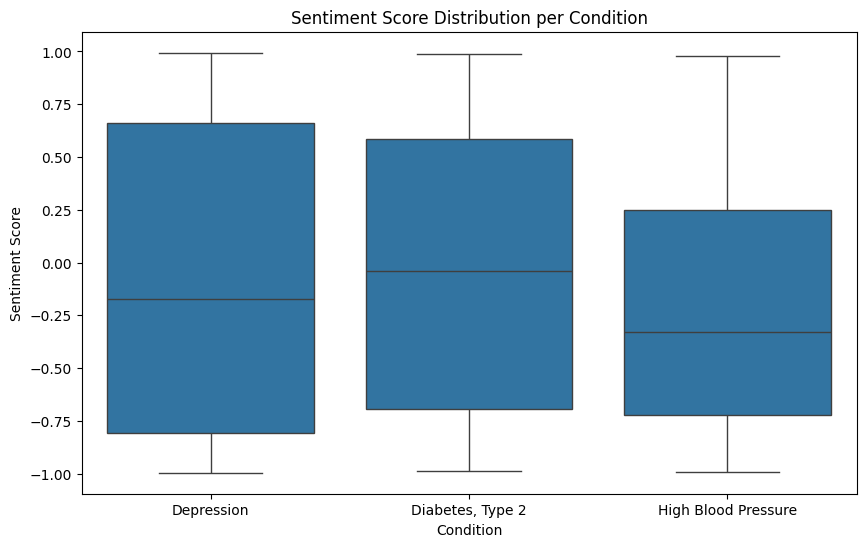

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='sentiment_score', data=df_filtered)
plt.title('Sentiment Score Distribution per Condition')
plt.xlabel('Condition')
plt.ylabel('Sentiment Score')
plt.show()


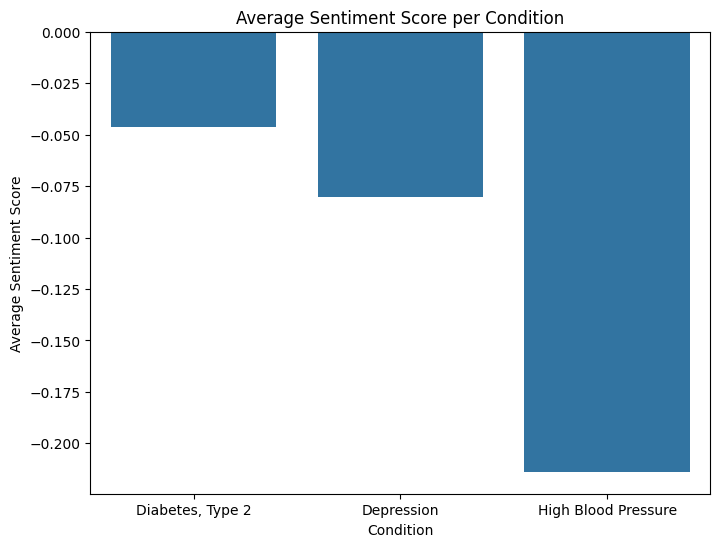

In [22]:
avg_sentiment = df_filtered.groupby('condition')['sentiment_score'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_sentiment.index, y=avg_sentiment.values)
plt.title('Average Sentiment Score per Condition')
plt.xlabel('Condition')
plt.ylabel('Average Sentiment Score')
plt.show()

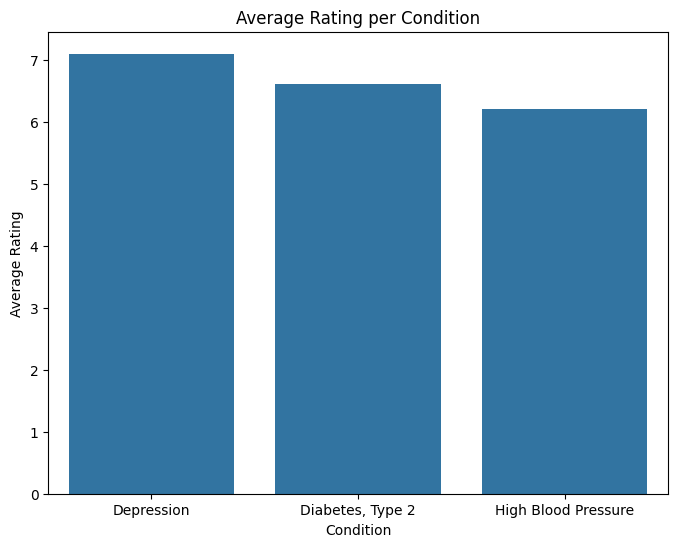

In [23]:
avg_rating = df_filtered.groupby('condition')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_rating.index, y=avg_rating.values)
plt.title('Average Rating per Condition')
plt.xlabel('Condition')
plt.ylabel('Average Rating')
plt.show()

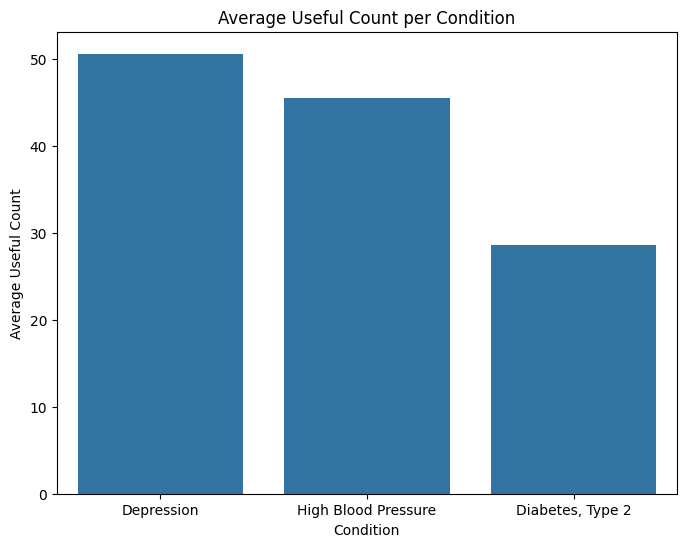

In [24]:
avg_useful = df_filtered.groupby('condition')['usefulCount'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_useful.index, y=avg_useful.values)
plt.title('Average Useful Count per Condition')
plt.xlabel('Condition')
plt.ylabel('Average Useful Count')
plt.show()

In [25]:
import nltk

In [26]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\udits\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [27]:
# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|@\w+', '', text)  # Remove URLs and mentions
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df_filtered['review'] = df_filtered['review'].apply(preprocess_text)

In [28]:
# Feature Engineering - using only review
X = df_filtered['review']
y = df_filtered['condition']


# Apply SMOTE for oversampling 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # First split

# Initialize LabelEncoder and fit it on the target variable
label_encoder = LabelEncoder()
y_temp_encoded = label_encoder.fit_transform(y_temp)
y_test_encoded = label_encoder.transform(y_test)  # Use transform, not fit_transform here!

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features
X_temp_tfidf = tfidf_vectorizer.fit_transform(X_temp)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_temp_tfidf, y_temp_encoded)

# Split the resampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42) # Second split on resampled data

print("Shape of X_train after SMOTE:", X_train.shape)
print("Shape of y_train after SMOTE:", y_train.shape)
print("Shape of X_test:", X_test_tfidf.shape)
print("Shape of y_test:", y_test_encoded.shape)

Shape of X_train after SMOTE: (17445, 10000)
Shape of y_train after SMOTE: (17445,)
Shape of X_test: (2789, 10000)
Shape of y_test: (2789,)


In [29]:
# Model Training and Selection
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Use X_train and y_train
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    results[name] = accuracy
    print(f'{name}: {accuracy}')

Naive Bayes: 0.9544639655790605
Logistic Regression: 0.9526712083183937
SVM: 0.9619935460738616
Decision Tree: 0.9164575116529222
Random Forest: 0.9533883112226604
Gradient Boosting: 0.9383291502330584
XGBoost: 0.9591251344567946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161383
[LightGBM] [Info] Number of data points in the train set: 17445, number of used features: 3068
[LightGBM] [Info] Start training from score -1.098956
[LightGBM] [Info] Start training from score -1.100161
[LightGBM] [Info] Start training from score -1.096722
LightGBM: 0.9630692004302618


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [30]:
# Select the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

# Classification Report for the Best Model:
print("Classification Report for the Best Model:")
print(classification_report(y_test_encoded, best_model.predict(X_test_tfidf), zero_division=0))

Best Model: LightGBM
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1800
           1       0.97      0.95      0.96       501
           2       0.91      0.92      0.92       488

    accuracy                           0.96      2789
   macro avg       0.95      0.95      0.95      2789
weighted avg       0.96      0.96      0.96      2789



C:\Users\udits\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [32]:
# Save the best model and TF-IDF vectorizer
joblib.dump(best_model, 'best_drug_condition_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']